# Testing CNN With Different Test Set
Okay, so I've downloaded all the test images from post \#13 and I've saved them onto S3. Let's take a look at all of them

## Download Test Set From S3

In [1]:
# Install tflearn
import os
os.system("sudo pip install tflearn tqdm boto3 opencv-python")

0

In [73]:
import cv2
import numpy as np
import pandas as pd
import urllib
import boto3
import math
import os
import copy
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Connect to s3 bucket
s3 = boto3.resource('s3', region_name = 'ca-central-1')
my_bucket = s3.Bucket('2017edmfasatb')

In [16]:
# Get all files in the project directory under chi_lars_face_detection/photos/
test_photos = [i.key for i in my_bucket.objects.all() if 'chi_lars_face_detection/images/test_set/' in i.key]

# Pop off first element because it's just the root directory
test_photos = test_photos[1:]

In [31]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
#     # Build resize into function
#     image = cv2.resize(image, (91, 91))

    # Return the image
    return image

In [32]:
# Loop through all files to download into a single array from AWS
url_prefix = 'https://s3.ca-central-1.amazonaws.com/2017edmfasatb'

In [33]:
# Trying out the new tqdm library for progress bar
test_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(test_photos)]

100%|██████████| 24/24 [00:08<00:00,  3.06it/s]


In [34]:
# Convert to numpy arrays
test_photos_np = np.array(test_photos_list)

In [35]:
# View shape of numpy array
test_photos_np.shape

(24, 354, 353)

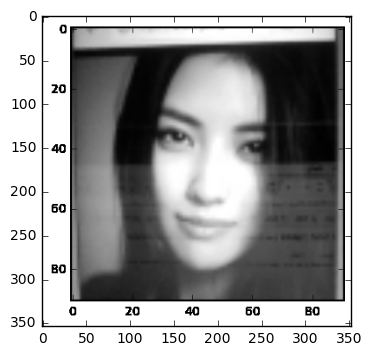

In [36]:
# Show test image in matplotlib
plt.imshow(test_photos_np[0], cmap='gray')

Hmm, actually, I forgot that I took these screenshots directly from the matplotlib output of post \#13... Here's the image I got when I googled "asian woman". I'll need to rewrite my **url_to_image** function to ensure I crop the right portions of the image.

The x coordinates look like they should be from roughly 40 to 345 pixels, and y coordinates look like they should be from 10 pixels to 335 pixels or something like that.

I've also forgotten to resize the image... so let's do that as well.

## Crop And Download S3 Again

In [68]:
# Define function to convert URL to numpy array
def url_to_image(url):
    # Download the image, convert it to a numpy array, and then read it into OpenCV format
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
    # Crop
    image = image[20:320, 40:335]
    
    # Build resize into function
    image = cv2.resize(image, (91, 91))

    # Return the image
    return image

I iteratively found the right crop values to use so they're not quite what I had said before.

In [69]:
# Trying out the new tqdm library for progress bar
test_photos_list = [url_to_image(os.path.join(url_prefix, x)) for x in tqdm(test_photos)]

100%|██████████| 24/24 [00:09<00:00,  2.93it/s]


In [70]:
# Convert to numpy arrays
test_photos_np = np.array(test_photos_list)

In [71]:
# View shape of numpy array
test_photos_np.shape

(24, 91, 91)

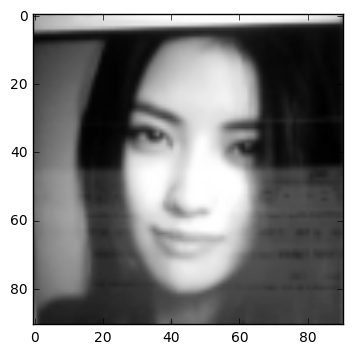

In [72]:
# Show test image in matplotlib
plt.imshow(test_photos_np[0], cmap='gray')

Let's see all of them.

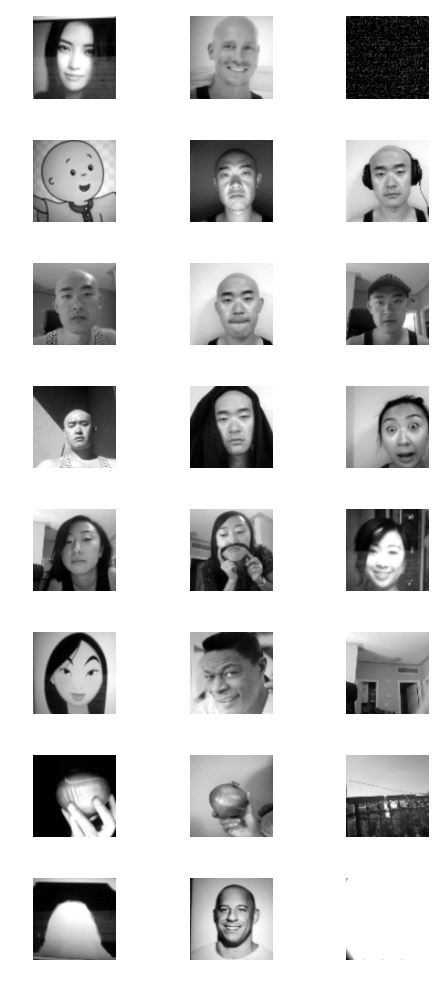

In [76]:
# Iterate and show of image resize and picture quality
images_to_plot = 24
n_cols = 3

fig, ax = plt.subplots(nrows = int(math.ceil(images_to_plot / n_cols)), ncols = n_cols, figsize = (5, 10))

i = 0
for row in ax:
    for col in row:
        col.imshow(test_photos_np[i], cmap='gray')
        col.set_axis_off()
        
        i += 1

plt.tight_layout()
plt.show()

Looks about right to me!

## Feature Building
We've loaded our alternate test set from S3, but we still need to import our original train and test sets so we can re-train our models.

In [85]:
# Temporarily load from np arrays
chi_photos_np = np.load('chi_photos_np_0.03_compress.npy')
lars_photos_np = np.load('lars_photos_np_0.03_compress.npy')

In [86]:
# View shape of numpy array
chi_photos_np.shape

(203, 91, 91)

In [87]:
# Set width var
width = chi_photos_np.shape[-1]
width

91

## Scaling Inputs

In [77]:
# Try out scaler on a manually set data (min of 0, max of 255)
from sklearn.preprocessing import MinMaxScaler

In [78]:
# Set test data list to train on (min of 0, max of 255)
test_list = np.array([0, 255]).reshape(-1, 1)
test_list

array([[  0],
       [255]])

In [79]:
# Initialize scaler
scaler = MinMaxScaler()

In [80]:
# Fit test list
scaler.fit(test_list)

/Users/chiwang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

## Reshaping 3D Array To 4D Array

In [90]:
chi_photos_np = chi_photos_np.reshape(-1, width, width, 1)
test_photos_np = test_photos_np.reshape(-1, width, width, 1)

## Putting It All Together

In [91]:
# Reshape to prepare for scaler
chi_photos_np_flat = chi_photos_np.reshape(1, -1)
print(chi_photos_np_flat[:10])

test_photos_np_flat = test_photos_np.reshape(1, -1)
print(test_photos_np_flat[:10])

[[135 139 139 ..., 210 142 136]]
[[161 166 172 ..., 255 255 255]]


In [93]:
# Scale
chi_photos_np_scaled = scaler.transform(chi_photos_np_flat)
print(chi_photos_np_scaled[:10])

test_photos_np_scaled = scaler.transform(test_photos_np_flat)
print(test_photos_np_scaled[:10])

[[ 0.52941176  0.54509804  0.54509804 ...,  0.82352941  0.55686275
   0.53333333]]
[[ 0.63137255  0.65098039  0.6745098  ...,  1.          1.          1.        ]]


In [94]:
# Reshape to prepare for scaler
lars_photos_np_flat = lars_photos_np.reshape(1, -1)
lars_photos_np_scaled = scaler.transform(lars_photos_np_flat)

In [95]:
# Reshape
chi_photos_reshaped = chi_photos_np_scaled.reshape(-1, width, width, 1)
lars_photos_reshaped = lars_photos_np_scaled.reshape(-1, width, width, 1)
test_photos_reshaped = test_photos_np_scaled.reshape(-1, width, width, 1)

print('{} has shape: {}'. format('chi_photos_reshaped', chi_photos_reshaped.shape))
print('{} has shape: {}'. format('lars_photos_reshaped', lars_photos_reshaped.shape))
print('{} has shape: {}'. format('test_photos_reshaped', test_photos_reshaped.shape))

chi_photos_reshaped has shape: (203, 91, 91, 1)
lars_photos_reshaped has shape: (200, 91, 91, 1)
test_photos_reshaped has shape: (24, 91, 91, 1)


In [96]:
# Create copy of chi's photos to start populating x_input
x_input = copy.deepcopy(chi_photos_reshaped)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (203, 91, 91, 1)


In [97]:
# Concatentate lars' photos to existing x_input
x_input = np.append(x_input, lars_photos_reshaped, axis = 0)

print('{} has shape: {}'. format('x_input', x_input.shape))

x_input has shape: (403, 91, 91, 1)


## Preparing Labels

In [98]:
# Create label arrays
y_chi = np.array([[1, 0] for i in chi_photos_reshaped])
y_lars = np.array([[0, 1] for i in lars_photos_reshaped])

print('{} has shape: {}'. format('y_chi', y_chi.shape))
print('{} has shape: {}'. format('y_lars', y_lars.shape))

y_chi has shape: (203, 2)
y_lars has shape: (200, 2)


In [99]:
# Preview the first few elements
y_chi[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [100]:
y_lars[:5]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [101]:
# Create copy of chi's labels to start populating y_input
y_input = copy.deepcopy(y_chi)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (203, 2)


In [102]:
# Concatentate lars' labels to existing y_input
y_input = np.append(y_input, y_lars, axis = 0)

print('{} has shape: {}'. format('y_input', y_input.shape))

y_input has shape: (403, 2)


## CNN \#1 - Less Convolutional Filters

In [103]:
# TFlearn libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [104]:
convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_1')
convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

convnet = conv_2d(convnet, 3, 10, activation = 'relu', name = 'conv_2')
convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
convnet = dropout(convnet, 0.8, name = 'dropout_1')

convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')

### Train Test Split

In [106]:
# Import library
from sklearn.model_selection import train_test_split

In [107]:
print(x_input.shape)
print(y_input.shape)

(403, 91, 91, 1)
(403, 2)


In [108]:
# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size = 0.1, stratify = y_input)

x_train = np.array(x_train, dtype = np.float64)
x_test = np.array(x_test, dtype = np.float64)
y_train = np.array(y_train, dtype = np.float64)
y_test = np.array(y_test, dtype = np.float64)

### Training

In [27]:
# Train with data
model = tflearn.DNN(convnet)
model.fit(
    {'input': x_train},
    {'targets': y_train},
    n_epoch = 10,
    validation_set = ({'input': x_test}, {'targets': y_test}),
    snapshot_step = 500,
    show_metric = True
)

Training Step: 59  | total loss: 0.13480 | time: 0.107s
| SGD | epoch: 010 | loss: 0.13480 - acc: 0.9952 -- iter: 320/362
Training Step: 60  | total loss: 0.12240 | time: 1.133s
| SGD | epoch: 010 | loss: 0.12240 - acc: 0.9958 | val_loss: 0.03329 - val_acc: 1.0000 -- iter: 362/362
--


### View Convolutional Filters

## CNN \#2 - Smaller Filter Sizes
I used a 10 x 10 filter in each of the layers... let's go down to a... I dunno, maybe 3 x 3 just for fun?

Training Step: 35  | total loss: 0.42921 | time: 0.096s
| SGD | epoch: 006 | loss: 0.42921 - acc: 0.9963 -- iter: 320/362
Training Step: 36  | total loss: 0.41741 | time: 1.120s
| SGD | epoch: 006 | loss: 0.41741 - acc: 0.9971 | val_loss: 0.33021 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


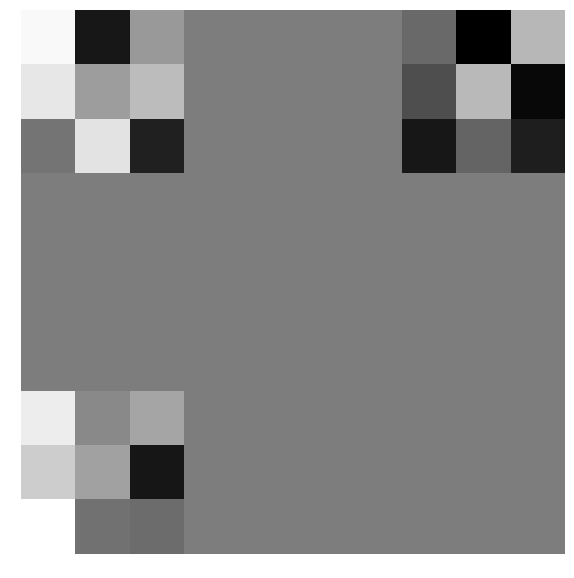

There are 9 filters in conv_2


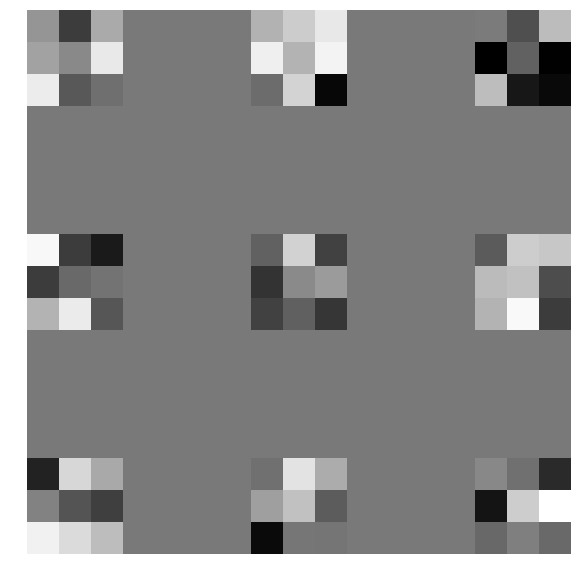

In [31]:
import tensorflow as tf

with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 3, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')

First of all, I had to import tensorflow and add in

~~~~
with tf.Graph().as_default():
~~~~

to somehow separate the new model into another "graph session". What are these? I'm not sure, but this [stack overflow inquiry](https://stackoverflow.com/questions/39887397/how-to-use-two-nets-in-tflearn?rq=1) helped me out a bit. With that, I got my new model training with the same variable names where it was giving me an error earlier.

I trained the model until 6 epochs because that's when I saw accuracy peak. A manual early stopping mechanism, if you will. Even with 6 epochs and only 3 x 3 filters with 3 filters per convolutional layer, we still reach 99% accuracy!

Again, the filters don't quite mean anything to me (I'm not sure it _**can**_ mean anything being 3 pixels by 3 pixels), but I do see some generally brighter colored filters and darker colored filters... perhaps these could represent the face / background and hair respectively!

Let's try going the other way and making huge filters... why not just cover the entire photo... let's try it out.

## CNN \#3 - Larger Filter Sizes
Let's just use a 91 x 91 filter and see what happens. Maybe this will lend itself to a recognizable filter a bit more.

Training Step: 35  | total loss: 0.03914 | time: 0.279s
| SGD | epoch: 006 | loss: 0.03914 - acc: 0.9951 -- iter: 320/362
Training Step: 36  | total loss: 0.03266 | time: 1.344s
| SGD | epoch: 006 | loss: 0.03266 - acc: 0.9961 | val_loss: 0.00603 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


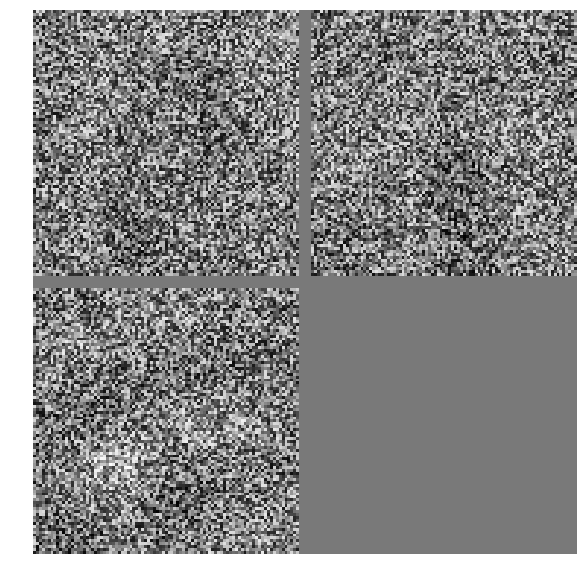

There are 9 filters in conv_2


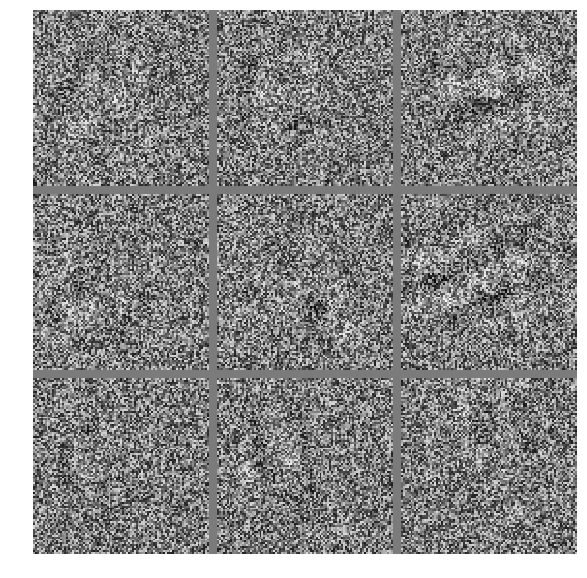

In [32]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 6,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')

Interesting, it still doesn't quite make sense to me, but it's starting to take some type of shape in the second level filters. In that bottom right one in the second layer filters, I can almost even see a face if I squint... Or maybe that's just my hope and dreams deceiving my eyes right before me. I'm not even sure if we'd be able to really make any sense of the second layer filters because they would be filtering on the activations / outputs of the first layer filter. Only the first layer filter is a filter acting on the original image itself. It's plausible that one of these may have the silhouette of a person because my filter size is the size of the entire image. There theoretically isn't even any strides happening here.

Regardless, we would love to see the filters [take a smoothed shape](http://cs231n.github.io/understanding-cnn/) as that will indicate the filters have successfully learned some kind of pattern.

Let's try 3 layers to see what kind of difference that makes.

## CNN \#4 - More Convolutional Layers

Training Step: 59  | total loss: 0.34903 | time: 0.483s
| SGD | epoch: 010 | loss: 0.34903 - acc: 0.9584 -- iter: 320/362
Training Step: 60  | total loss: 0.30831 | time: 1.597s
| SGD | epoch: 010 | loss: 0.30831 - acc: 0.9639 | val_loss: 0.01252 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


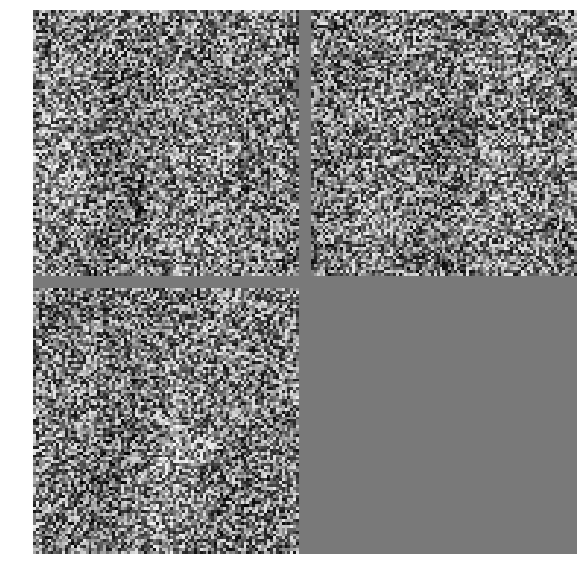

There are 9 filters in conv_2


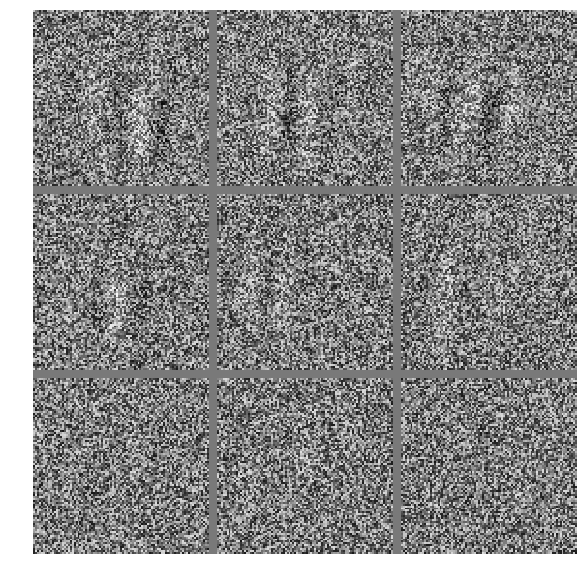

There are 9 filters in conv_3


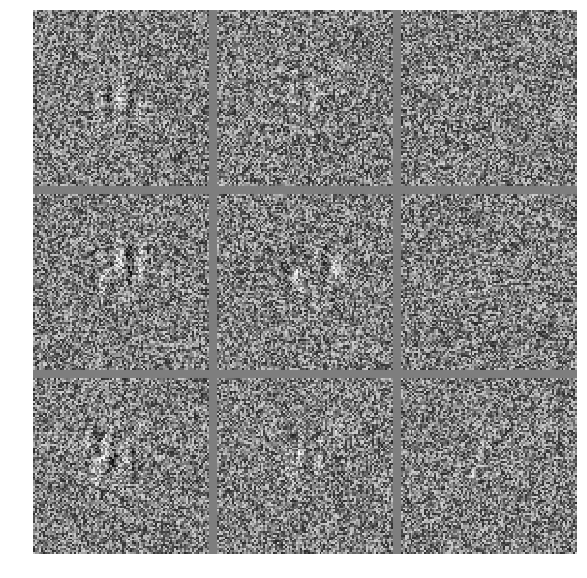

In [43]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_2')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_2')
    
    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_3')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_3')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 10,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')
    display_convolutions(model, 'conv_2')
    display_convolutions(model, 'conv_3')

My first thought... how come the third convolution layer only has 9 filters as well? Each output from the second layer (9 outputs) should each be convoluted with the 3 third-layer convolution filter, creating 27 outputs, no? That seems to be what happened between convolutional layers 1 and 2, but I'm not sure why the third filter doesn't follow this logic... I guess that's what I get for using a method I'm not too familiar with, on a python package I'm not too familiar with, while viewing the filters through a copied and pasted code I'm not too familiar with.

Baby steps, though, let's not worry about that too much right now as it looks like it is still giving me the filters (or perhaps at least a subset of the 3rd convolutional layer filters) for each convolutional layer. In fact, I'm going to remove the third layer altogether because it's way too abstracted for me to understand right now and probably just complicates things.

We are actually starting to see the emergence of some smoother shapes throughout all the filters. The filters are still quite grainy in the grand scheme of things, so maybe I need to train it longer and see if the filters smooth out even more... let's just go crazy and do 200 epochs. Well, I guess if I were really crazy I'd leave it to train for thousands of epochs overnight, but let's call 20x more epochs "crazy" for now. Plus, it converges to like 99% accuracy after the 6th epoch anyways.

I also realized that if I'm using a filter size of 91, then the output of my first convolution is probably a single pixel as there is only one unique location that a 91 pixel wide filter can have on a 91 pixel wide image! I'm not even sure how it's doing the second convolution at this point because how can you convolute a 1 pixel wide image with a 91 pixel wide filter? Hmm let's just train 1 convolution layer as well.

## CNN \#5 - More Epochs

Training Step: 599  | total loss: 0.04104 | time: 0.148s
| SGD | epoch: 100 | loss: 0.04104 - acc: 0.9938 -- iter: 320/362
Training Step: 600  | total loss: 0.03810 | time: 1.182s
| SGD | epoch: 100 | loss: 0.03810 - acc: 0.9944 | val_loss: 0.00898 - val_acc: 1.0000 -- iter: 362/362
--
There are 3 filters in conv_1


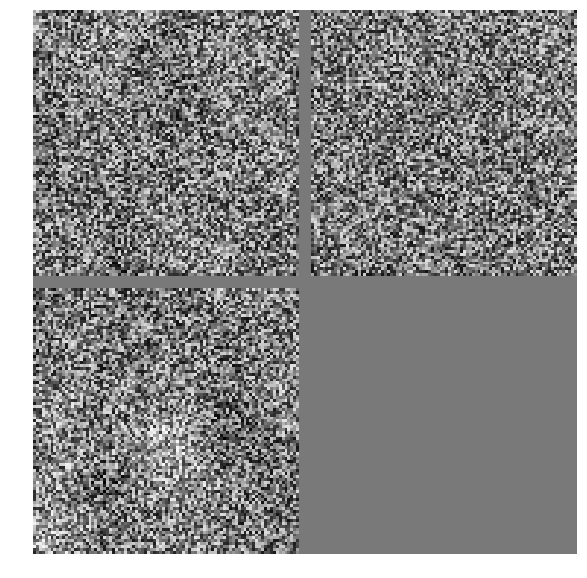

In [60]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 3, 91, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.001, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 100,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')

At about 0.15s per epoch, plus overhead time, this took us around 3 mins to train. Not too shabby! The top two filters don't look too smooth to me, but filter on the bottom, call me crazy, _**kind of**_ has an outline of somebody with long hair. Note quite as crisp as the mock up I drew:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/47_silhouette.png" style="width: 500px;"/>

But I do see the general shape! The fact that my 91 x 91 filter theoretically yields an output of 1 pixel really bothers me... I don't quite want to go back to 10 pixels yet either though, because that really didn't do much for me. I'm going to try keeping one layer, but more filters of a smaller size.

## CNN \#6 - More Filters, Smaller Filter Size

Training Step: 599  | total loss: 0.03676 | time: 0.151s
| SGD | epoch: 100 | loss: 0.03676 - acc: 0.9946 -- iter: 320/362
Training Step: 600  | total loss: 0.03411 | time: 1.186s
| SGD | epoch: 100 | loss: 0.03411 - acc: 0.9951 | val_loss: 0.00794 - val_acc: 1.0000 -- iter: 362/362
--
There are 9 filters in conv_1


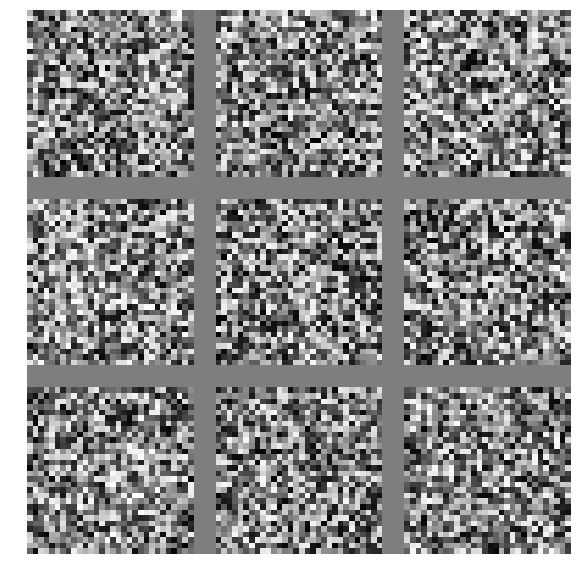

In [62]:
with tf.Graph().as_default():
    # Build CNN
    convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

    convnet = conv_2d(convnet, 9, 30, activation = 'relu', name = 'conv_1')
    convnet = max_pool_2d(convnet, 2, name = 'max_pool_1')

    convnet = fully_connected(convnet, 1024, activation = 'relu', name = 'fully_connected_1')
    convnet = dropout(convnet, 0.8, name = 'dropout_1')

    convnet = fully_connected(convnet, 2, activation = 'softmax', name = 'fully_connected_2')
    convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.001, loss = 'categorical_crossentropy', name = 'targets')
       
    # Train Model
    model = tflearn.DNN(convnet)
    model.fit(
        {'input': x_train},
        {'targets': y_train},
        n_epoch = 100,
        validation_set = ({'input': x_test}, {'targets': y_test}),
        snapshot_step = 500,
        show_metric = True
    )
    
    # Display convolutional filters
    display_convolutions(model, 'conv_1')

Not really doing too much here. I think my experiment and test set here is a little _**too controlled**_ because, with any model, as soon as I get up to 6-7 epochs my validation accuracy goes to 100%. Realistically, the test set is so similar to the training set that there really is no difference other than odd facial experessions here and there.

I think what I need to do perhaps is to actually use the test photos I took in post \#13 (me with pants on my head, holding the onion... etc) as my test set and validate on those to get a more natural sense of how the model is doing.

Let's continue this in our next post.